**ОГЛАВЛЕНИЕ:**

1. [Знакомство с данными](#knowledge)
2. [Предобработка данных](#processing)
    * [Корректировка названий столбцов](#columns)
    * [Работа с пропусками](#nan)
    * [Проверка данных на явные и неявные дубликаты](#duplicates)
    * [Проверка количественных данных](#count)
3. [Исследовательский анализ данных](#search)
     * [Анализ клиентов банка в целом](#clients_in_general)
     * [Анализ оттока клиентов](#churn)
     * [Промежуточные выводы](#section_conclusion)
4. [Проверка статистических гипотез](#hypotheses)
5. [Выводы](#total)

<a id="knowledge"></a> 

## Знакомство с данными ##

In [99]:
# импорт библиотек

import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from pylab import *
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go 

In [100]:
# прочитаем и сохраним файл в переменную

data = pd.read_csv('C:/Users/User/Desktop/Проекты курса/Проект №2/bank_dataset.csv')

data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


### Описание датасетов

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

In [101]:
# выведем общую информацию о датафрейме

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Датафрейм имеет 12 столбцов, 10000 строк. Можно заметить пропуски в столбце 'Balance', их необходимо рассмотреть подробнее и решить - оставлять без изменений или обработать.

Также, стоит обратить внимание на названия столбцов. Все они написаны по-разному. В дальнейшем их необходимо привести к одному виду, например, привести к нижнему регистру.
Типы данных оставим без изменений.

<a id="processing"></a> 

## Предобработка данных ##

<a id="columns"></a>
**Корректировка названий столбцов**

In [102]:
# изменяем на нижний регистр названия столбцов

data.columns = data.columns.str.lower()

# разделяем слова с помощью разделителя

data = data.rename(columns={'userid':'user_id', 'creditcard':'credit_card'})

# проверим столбцы после изменений

data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

Мы привели названия столбцов к нижнему регистру и где необходимо добавили разделитель.

<a id="nan"></a> 
**Работа с пропусками**

In [103]:
# выведем количество пропусков в датафрейме

data.isna().sum()

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

In [104]:
# описательная статистика столбца 'balance'

data.balance.describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

С помощью описательной статистики мы видим, что суммы на балансе клиентов варьируются от 3769 руб. до 250898 руб.  

Медианное значение составляет 119832 руб., что описывает 50 % данных столбца.

Что касается пропусков, то 36 % данных отсутствуют в столбце 'balance'. Это достаточно высокий показатель для удаления. 

Заменить пропуски логическим путем нельзя. Также, не будет иметь смысла заполнить пропуски нулем.

Суммы на балансе клиентов, в целом, для нас не являются важной информацией для анализа. Пропуски возникли скорее всего из-за отсутствия денежных средств на балансе, либо из-за ошибки при выгрузке данных. В связи с этим, можно оставить пропуски без обработки.

<a id="duplicates"></a>
**Проверка данных на явные и неявные дубликаты**

In [105]:
# проверим, сколько дубликатов есть в датафрейме

data.duplicated().sum()

0

In [106]:
# проверим наличие явных дубликатов сразу в нескольких столбцах

data.duplicated(subset=['user_id','score','city']).sum()

0

In [107]:
# проверим все ли пользователи встречаются в датафрейме 1 раз

data['user_id'].duplicated().sum()

0

Явных дубликатов в датафрейме нет.

In [108]:
# проверим столбец 'city' на неявные дубликаты

data.city.unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [109]:
# проверим столбец 'gender' на неявные дубликаты

data.gender.unique()

array(['Ж', 'М'], dtype=object)

Данные в столбцах 'city' и 'gender' занесены корректно.

<a id="count"></a>
**Проверка количественных данных**

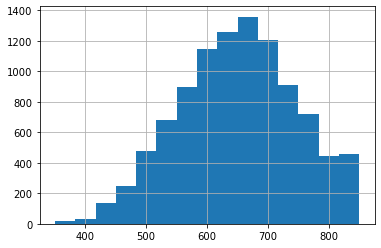

In [110]:
# проверим распределение данных столбца 'score', где указаны скоринговые баллы клиентов

data.score.hist(bins=15);

In [111]:
# описательная статиска столбца 'score'

data.score.describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64

Мы видим на гистограмме, что большинство клиентов получали скоринговые баллы в диапазоне от 600 до 700.Гистограмма ассиметрична, т.е. нормального распределения нет.

Меньше 200 клиентов имели скоринговые баллы от 350 до 450.

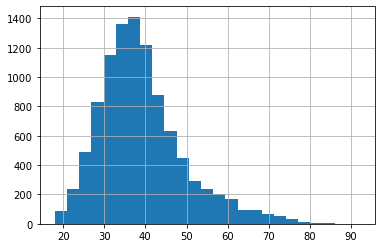

In [112]:
# проверим распределение данных столбца 'age', где указан возраст клиентов

data.age.hist(bins=25);

По данной гистограмме можем сделать вывод, что нормального распределения значений нет.

In [113]:
# описательная статистика столбца 'age'

data['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

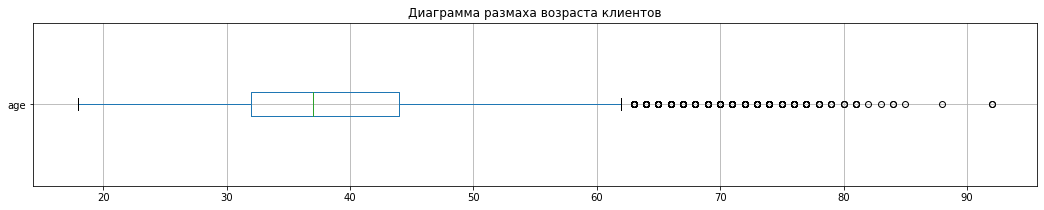

In [114]:
# построим диаграмму размаха и посмотрим, как распределен возраст клиентов

fig, ax = plt.subplots(figsize = (18,3))
ax = data[['age']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха возраста клиентов');

Большинство клиентов в банке - люди в возрасте 32-44 лет. Реже встречаются клиенты старше 62 лет.

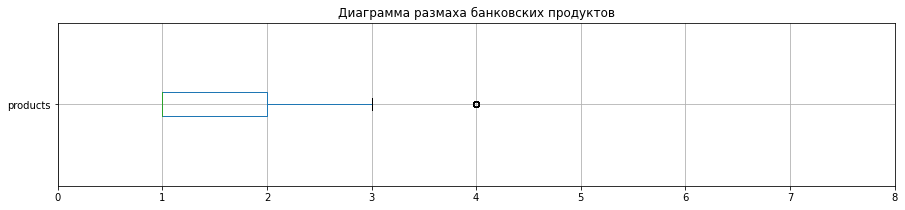

In [115]:
# построим диаграмму размаха и посмотрим, как распределены банковские продукты

fig, ax = plt.subplots(figsize = (15,3))
ax = data[['products']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха банковских продуктов')
plt.xlim(0,8);

In [116]:
# проверим, сколько клиентов имеют 4 банковских продукта

data.query('products == 4').shape[0]

60

В основном клиенты пользуются 1-3 банковскими продуктами. 60 клиентов или 0,6 % имеют 4 банковских продукта.

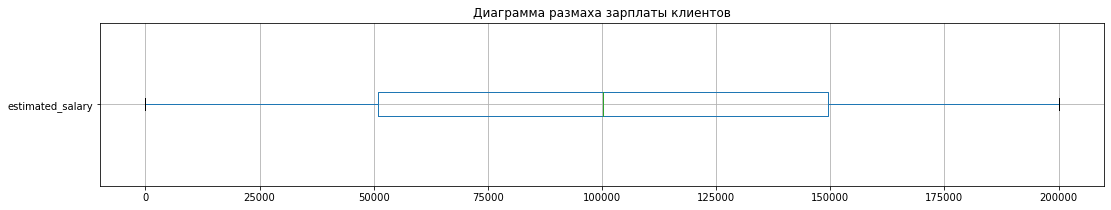

In [117]:
# Посмотрим на распределение дохода клиентов        

fig, ax = plt.subplots(figsize = (18,3))
ax = data[['estimated_salary']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха зарплаты клиентов');

In [118]:
# описательная статистика столбца 'estimated_salary'

data.estimated_salary.describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

In [119]:
# посчитаем, сколько человек указали доход меньше 1000

data.query('estimated_salary < 1000').shape[0]

59

Доход клиентов очень разный. Мы встречаем в данных зарплату 11.58. Для того, чтобы определить зарплату клиентов, которая не соответствует реальности, мы сделали фильтр по клиентам и оставили тех, чья зарплата меньше 1000 руб.  Их количество составляет 59 или 0,59 %. Нельзя исключать тот факт, что клиенты могли некорректно указать свой доход при заполнении анкеты, из-за чего возникли такие цифры. Будем считать такие данные аномальными и для дальнейшего анализа исключим их из датафрейма. 

Под доходом клиента можно понимать, как зарплату от работодателя, пенсию, доход, который могут получать клиенты - самозанятые.

In [120]:
# исключим доход клиентов, который < 1000

data = data.query('estimated_salary >= 1000')

In [121]:
# выведем количество строк после удаления аномальных данных

data.shape[0]

9941

В итоге, общее количество строк в датафрейме после удаления составляет 9941.

In [122]:
# проверим, какие данные хранятся в столбце 'credit_card'

data['credit_card'].unique()

array([1, 0], dtype=int64)

0 - нет кредитной карты


1 - есть кредитная карта

In [123]:
# проверим, какие данные хранятся в столбце 'churn'

data['churn'].unique()

array([1, 0], dtype=int64)

0 - клиент остался с банком

1 - клиент ушел от обслуживания банка

<a id="search"></a>
## Исследовательский анализ данных ##

<a id="clients_in_general"></a>
### Анализ клиентов банка в целом ##

<a id="city"></a>
**Проанализируем клиентов по городам**

In [124]:
data.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [125]:
# Рассмотрим каждый город и посчитаем количество клиентов

clients_city = data.groupby('city',as_index=False)['user_id'].count()
clients_city

,city,user_id
0,Ростов Великий,2492
1,Рыбинск,2469
2,Ярославль,4980


In [126]:
# построим круговую диаграмму, где отразим количество клиентов по городам

fig = go.Figure(data=[go.Pie(labels=clients_city['city'], 
                             values=clients_city['user_id'],
                             textinfo='label+percent')])

fig.update_layout(title='Распределение клиентов по городам')
fig.show() 

В Ростове Великом и Рыбинске практически равное количество клиентов, 25.1 % и 24.8 % соответственно. В головном банке,в Ярославле, числятся 4980 клиентов, что составляет 50.1 % от общего количества.

**Проанализируем клиентов по гендерному признаку**

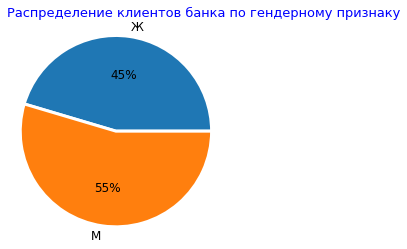

In [127]:
# определим, кого в качестве клиентов больше - мужчин или женщин
# построим круговую диаграмму

count_clients_gender = data.groupby('gender',as_index=False)[['user_id']].count()
                    
plt.pie(count_clients_gender['user_id'],
        labels=count_clients_gender['gender'],
        autopct='%1.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        radius=1.1,
        textprops={'fontsize': 12});
  

plt.title('Распределение клиентов банка по гендерному признаку',loc='left',color='b',fontsize = 13);

Как мы видим из диаграммы, мужчины чаще становятся клиентами банка, чем женщины. Количество мужчин составляет 55 %.

In [128]:
# сформируем диапазоны в зависимости от возраста клиента

data['range_age'] = pd.cut(
    x=data['age'],
    bins=[17,30,43,56,69,82,93],
    labels=['от 18 до 30', 'от 31 до 43', 'от 44 до 56',
                            'от 57 до 69','от 70 до 82','от 83 до 92'])


# проверим все ли верно отображается

data[['age','range_age']].head(10)

,age,range_age
0,42,от 31 до 43
1,41,от 31 до 43
2,42,от 31 до 43
3,39,от 31 до 43
4,43,от 31 до 43
5,44,от 44 до 56
6,50,от 44 до 56
7,29,от 18 до 30
8,44,от 44 до 56
9,27,от 18 до 30


In [129]:
# проверим все ли строки содержат данные

data.range_age.isna().sum()

0

In [130]:
# посчитаем, сколько людей в зависимости от возрастной категории числятся в банке

count_clients_age = data.groupby('range_age', as_index=False)['user_id'].count()

# добавим столбец, в котором отразим долю

count_clients_age['share'] = round( (count_clients_age['user_id'] / count_clients_age['user_id'].sum() * 100), 2)

count_clients_age

,range_age,user_id,share
0,от 18 до 30,1960,19.72
1,от 31 до 43,5400,54.32
2,от 44 до 56,1857,18.68
3,от 57 до 69,575,5.78
4,от 70 до 82,142,1.43
5,от 83 до 92,7,0.07


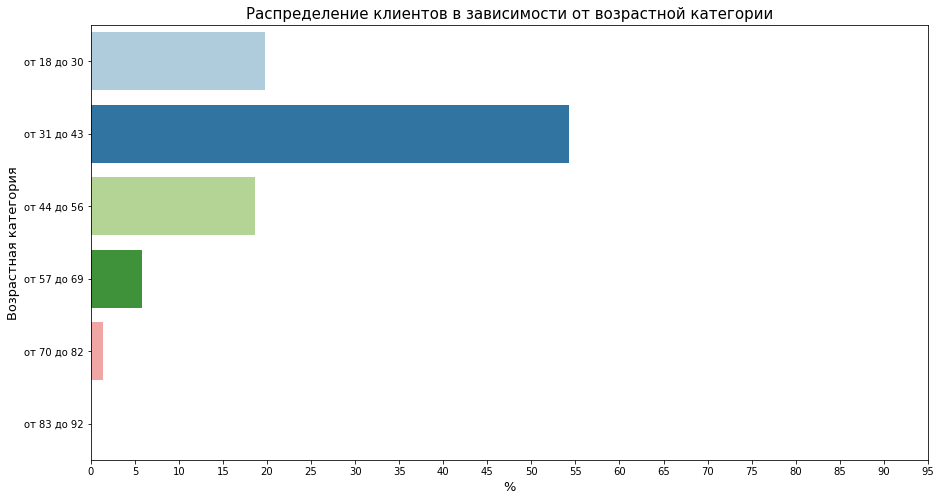

In [131]:
# отобразим количество людей в зависимости от возрастной категории

fig, ax = plt.subplots()

ax = sns.barplot(
    data=count_clients_age,
    y='range_age',
    x='share',
    orient='h',
    palette = 'Paired')

ax.set_title('Распределение клиентов в зависимости от возрастной категории',fontsize=15)

ax.set_xlabel('%', fontsize=13)

ax.set_ylabel('Возрастная категория',fontsize=13)

ax.set_xticks(np.arange(0,100,5));

fig.set_figheight(8) 

fig.set_figwidth(15)

55 % составляют клиенты в возрасте от 31 года до 43 лет. 

19 % и 18 %  клиентов - от 18 до 30 лет и от 44 до 56 лет соответственно.

Меньше 1 % клиентов - долгожителей.

**Проанализируем теперь скоринговые баллы.**

Баллы рассчитываются банком для определения вероятности возврата кредита заемщиком. Как мы видели из распределения даннных столбца 'score' в первой части исследования, они находятся в диапазоне от 350 до 850. Для того, чтобы проанализировать их более подробно и разделить клиентов, исходя из полученных баллов, необходимо классифицировать скоринговые баллы.

Классификация баллов будет происходить на основе общепринятой шкалы американской компании FICO, которая специализируется на разработке методологии скоринговых моделей. Сохраним новые данные в отдельном столбце датафрейма.

In [132]:
# напишем функцию для создания классификации скоринговых баллов

def score_category(score):
    if  350 <= score < 500:
        return 'Невозможно получить займ'
    
    elif 500 <= score < 600:
        return 'Нельзя кредитоваться в крупных фин.организациях'
    
    elif 600 <= score < 650:
        return 'Приемлемый результат (запрос доп.документов)'
    
    elif 650 <= score < 690:
        return 'Хороший показатель.Высокий шанс на стандартные условия'
    
    elif 690 <= score <= 850:
        return 'Надежный заемщик.Высокий шанс на лучшие условия'

In [133]:
# применим фукнцию и запишем результат в новый столбец

data['score_category'] = data['score'].apply(score_category)

data.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,range_age,score_category
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,от 31 до 43,Приемлемый результат (запрос доп.документов)
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,от 31 до 43,Приемлемый результат (запрос доп.документов)
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,от 31 до 43,Нельзя кредитоваться в крупных фин.организациях
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,от 31 до 43,Надежный заемщик.Высокий шанс на лучшие условия
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,от 31 до 43,Надежный заемщик.Высокий шанс на лучшие условия


In [134]:
# сгруппируем и посчитаем сколько клиентов приходится на каждую категорию скоринговых баллов

count_clients_score = data.groupby('score_category', as_index=False)['user_id']\
.count()\
.sort_values(by='user_id',ascending=False)

count_clients_score['share'] = round((count_clients_score['user_id'] / count_clients_score['user_id'].sum() * 100),1)

count_clients_score

,score_category,user_id,share
0,Надежный заемщик.Высокий шанс на лучшие условия,3479,35.0
2,Нельзя кредитоваться в крупных фин.организациях,2388,24.0
3,Приемлемый результат (запрос доп.документов),1852,18.6
4,Хороший показатель.Высокий шанс на стандартные...,1592,16.0
1,Невозможно получить займ,630,6.3


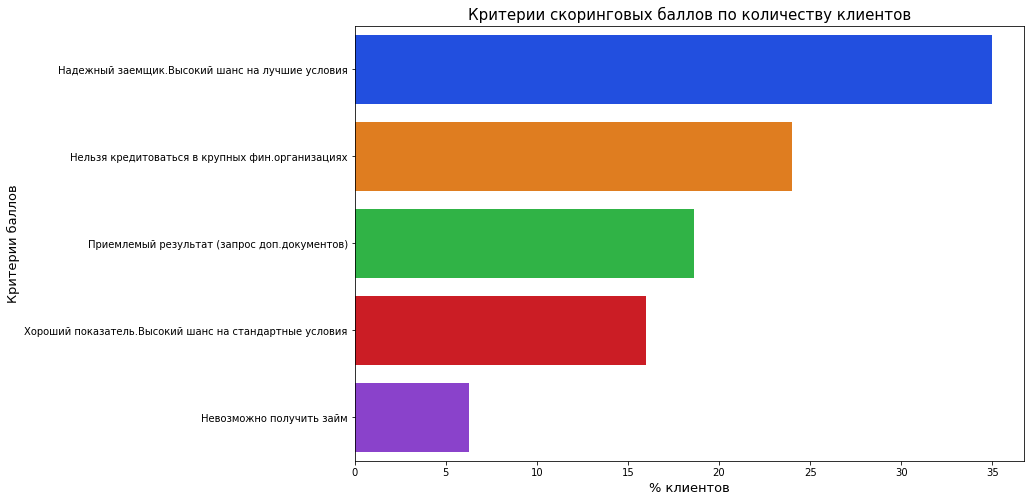

In [135]:
# построим столбчатую диаграмму для отражения количества клиентов по каждому критерию скоринговых баллов

fig, ax = plt.subplots()

ax = sns.barplot(
    data=count_clients_score,
    y='score_category',
    x='share',
    orient='h',
    palette = 'bright')

ax.set_title('Критерии скоринговых баллов по количеству клиентов',fontsize=15)

ax.set_xlabel('% клиентов', fontsize=13)

ax.set_ylabel('Критерии баллов',fontsize=13)

fig.set_figheight(8) 

fig.set_figwidth(12)

Мы видим, что у банка 35 % надежных клиентов, которые имеют высокие скоринговые баллы. Это говорит о том, что банк сможет рассчитывать на получение дохода в течение всего срока кредитования заемщиков. Но на втором месте,  24 % клиентов имеют невысокие баллы, что говорит о малой вероятности получить кредит в банке. Таким клиентам вероятно одобрят получение кредита в малых финансовых организациях. Получить кредитование вовсе не смогут 6 % клиентов.

Далее, посмотрим, как количество объектов в собственности связано со скоринговыми баллами.

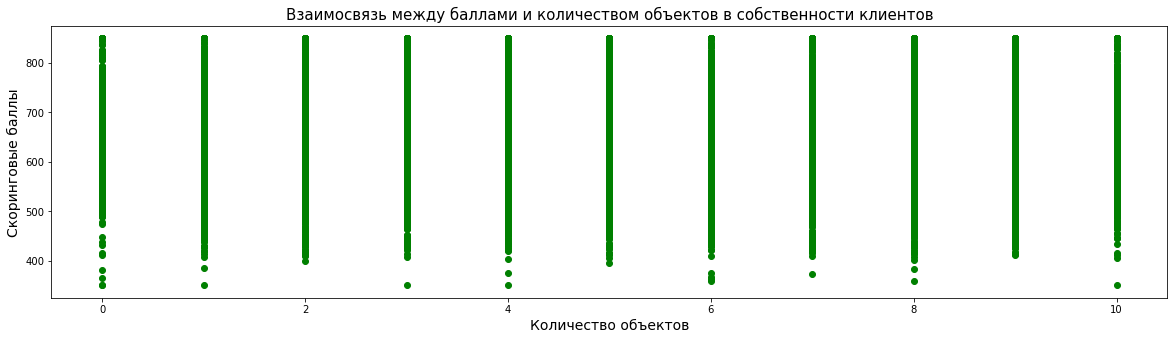

In [136]:
# построим диаграмму рассеяния для выявления взаимосвязи между баллами и количеством объектов

fig, ax = plt.subplots(figsize=(20, 5))

ax.scatter(x = data['objects'], y = data['score'], c = 'green')

ax.set_title('Взаимосвязь между баллами и количеством объектов в собственности клиентов',fontsize=15)

ax.set_xlabel("Количество объектов",fontsize=14)

ax.set_ylabel("Скоринговые баллы",fontsize=14);

По данном диаграмме рассеяния мы не видим связи между скоринговыми баллами и количеством объектов в собственности. Если, к примеру, взять для сравнения клиентов, у которых нет в собственности ни одного объекта, то можем увидеть часто встречающееся максимальное количество баллов. Из этого можно сделать вывод, что скоринговые баллы не зависят от количества объектов в собственности.

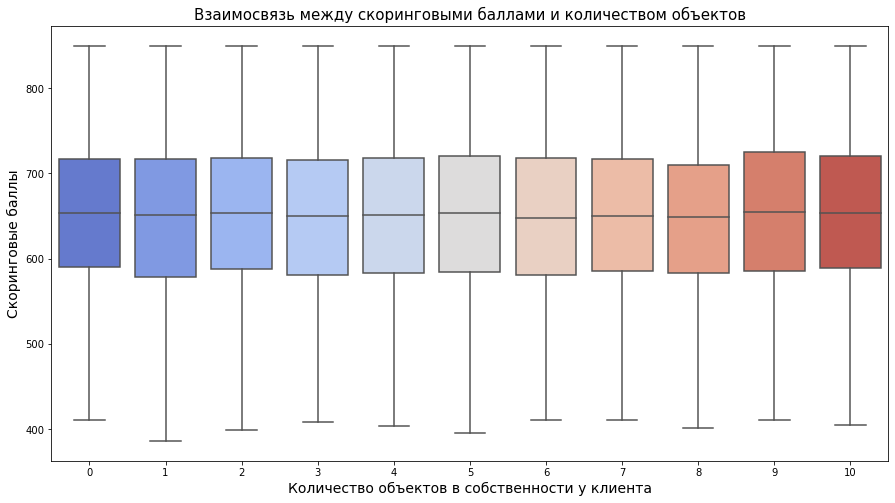

In [137]:
# построим диаграммы размаха одновременно по объектам и по баллам

fig, ax = plt.subplots(figsize = (15,8))

sns.boxplot(x='objects',
            y= "score",
            data=data,
            palette = 'coolwarm',
            showfliers=False)


plt.xlabel('Количество объектов в собственности у клиента',fontsize=14)

plt.ylabel('Скоринговые баллы',fontsize=14)

plt.title('Взаимосвязь между скоринговыми баллами и количеством объектов',fontsize=15);

По данным диаграммам размаха мы видим отсутствие связи между баллами и количеством объектов.  К каждому числу объектов относится примерно одинаковый объем данных по скоринговым баллам. Всем объектам соответствуют и минимальные, и максимальные баллы, т.е. данные не распределены по принципу - чем меньше количество баллов, тем меньше объектов у клиентов и ,наоборот.

**Проанализируем активность клиентов**

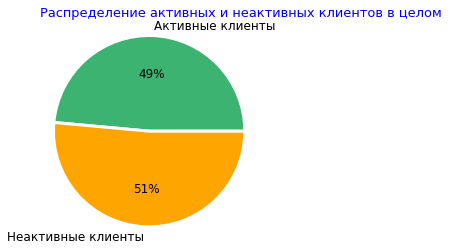

In [138]:
# проанализируем активность клиентов

count_clients_loyalty = data.groupby('loyalty',as_index=False)[['user_id']].count().replace({0:'Активные клиенты',1:'Неактивные клиенты'})
                    
plt.pie(count_clients_loyalty['user_id'],
        labels=count_clients_loyalty['loyalty'],
        autopct='%1.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        radius=1.1,
        textprops={'fontsize': 12},
        colors=['mediumseagreen','orange']);
  

plt.title('Распределение активных и неактивных клиентов в целом',loc='left',color='b',fontsize = 13);

Разница между активными и неактивными клиентам небольшая, всего 2 %, но тем не менее неактивных клиентов больше, чем активных.

In [139]:
# посмотрим на распределение активных и неактивных клиентов по городам

count_clients_loyalty_city = data.groupby(['loyalty', 'city'],as_index=False)[['user_id']]\
.count()\
.replace({0:'Активные клиенты',1:'Неактивные клиенты'})

count_clients_loyalty_city['share'] = round((count_clients_loyalty_city['user_id'] /count_clients_loyalty_city\
.groupby('city')['user_id']\
.transform(sum)) * 100, 2)

count_clients_loyalty_city

,loyalty,city,user_id,share
0,Активные клиенты,Ростов Великий,1253,50.28
1,Активные клиенты,Рыбинск,1161,47.02
2,Активные клиенты,Ярославль,2412,48.43
3,Неактивные клиенты,Ростов Великий,1239,49.72
4,Неактивные клиенты,Рыбинск,1308,52.98
5,Неактивные клиенты,Ярославль,2568,51.57


In [140]:
# отразим количество сетевых и несетевых заведений по категориям

fig = px.bar(count_clients_loyalty_city,
             x='city',
             y='share',
             title='Процентное соотношение активных и неактивных клиентов по городам',
             color='loyalty',
             height=600,
             width=900,
             labels={'city':'Город', 'share':'%', 'loyalty':'Категории клиентов'},
             barmode = 'group',
             color_discrete_sequence=px.colors.qualitative.Dark24)
fig.show()

Больше активных пользователей в Ростове Великом, но незначительно, всего на 0,56 %. 

В целом можно сказать, что во всех банках примерно одинаковое количество активных и неактивных клиентов. 

Активность клиента определяется количеством и объемом транзакций,а также наличием задолженности перед банком. 

**Проанализируем клиентов в зависимости от уровня зарплаты.**

In [141]:
# создадим столбец с разными диапазонами зарплат клиентов

data['range_salary'] = pd.cut(
    x=data['estimated_salary'],
    bins=[1000,10000,30000,50000,80000,100000,200000],
    labels=['от 1 000 до 10 000', 'от 10 001 до 30 000','от 30 001 до 50 000','от 50 001 до 80 000', 'от 80 001 до 100 000', 'от 100 001 до 200 000'])


# проверим все ли корректно отображается

data[['estimated_salary','range_salary']].head(10)

,estimated_salary,range_salary
0,101348.88,от 100 001 до 200 000
1,112542.58,от 100 001 до 200 000
2,113931.57,от 100 001 до 200 000
3,93826.63,от 80 001 до 100 000
4,79084.10,от 50 001 до 80 000
5,149756.71,от 100 001 до 200 000
6,10062.80,от 10 001 до 30 000
7,119346.88,от 100 001 до 200 000
8,74940.50,от 50 001 до 80 000
9,71725.73,от 50 001 до 80 000


In [142]:
# проверим нет ли пропусков

data.range_salary.isna().sum()

0

In [143]:
# сделаем группировку по возрастной категории, по определенному диапазону зарплат
# и посчитаем количество клиентов
# сохраним  результат в отдельную переменную

count_client_salary_age = data.groupby(['range_age','range_salary'], as_index=False)['user_id']\
.count()\
.sort_values(by=['range_age','user_id'], ascending=[True,False])

# добавим столбец, в котором отразим долю клиентов по каждой возрастной категории

count_client_salary_age['share'] = round((count_client_salary_age['user_id'] /count_client_salary_age\
.groupby('range_age')['user_id']\
.transform(sum)) * 100, 2)

count_client_salary_age.head()

,range_age,range_salary,user_id,share
5,от 18 до 30,от 100 001 до 200 000,1028,52.45
3,от 18 до 30,от 50 001 до 80 000,277,14.13
2,от 18 до 30,от 30 001 до 50 000,197,10.05
1,от 18 до 30,от 10 001 до 30 000,196,10.00
4,от 18 до 30,от 80 001 до 100 000,160,8.16


In [144]:
# создадим барплот

fig = px.bar(count_client_salary_age,
             x='range_age',
             y='share',
             title='Процентное соотношение клиентов по возрасту и по зарплате',
             color='range_salary',
             height=600,
             width=900,
             labels={'range_age':'Возраст клиентов', 'share':'%', 'range_salary':'Диапазон зарплат, руб.' },
             color_discrete_sequence=px.colors.qualitative.T10)


fig.show()

Клиенты всех возрастов имеют в основном высокий уровень заработной платы, доля таких клиентов в каждой возрастной категории составляет от 47.6 % до 57.1 %.  

Далее, следуют зарплаты среднего уровня. От 50 тыс. до 80 тыс. руб. получают от 14 - 18 % клиентов каждой возрастной категории.

До 5 % максимум клиентов в каждой возрастной категории имеют доход от 1000 до 10000 руб., что  является хорошим показателем для банка. 

В целом, уровень зарплат у клиентов находится на хорошем уровне и подтверждает тот факт, что надежных клиентов у банка больше.

**Проанализируем распределение количества банковских продуктов.**

In [145]:
# сгруппируем и посчитаем клиентов в зависимости от количества продуктов

count_client_products = data.groupby('products',as_index=False)['user_id'].count()

count_client_products

,products,user_id
0,1,5053
1,2,4562
2,3,266
3,4,60


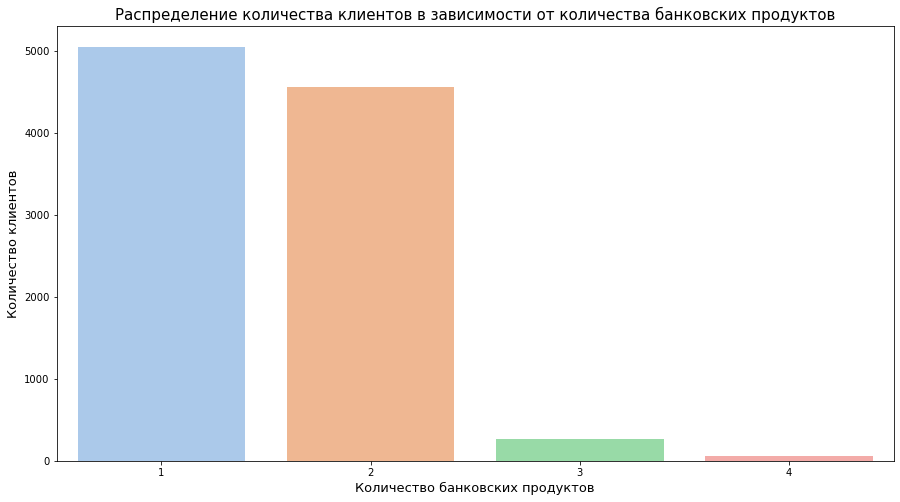

In [146]:
# создадим барплот по сгруппированной выше таблице

fig, ax = plt.subplots()

ax = sns.barplot(
    data=count_client_products,
    x='products',
    y='user_id',
    palette='pastel')

ax.set_title('Распределение количества клиентов в зависимости от количества банковских продуктов',fontsize=15)

ax.set_xlabel('Количество банковских продуктов', fontsize=13)

ax.set_ylabel('Количество клиентов',fontsize=13)

fig.set_figheight(8) 

fig.set_figwidth(15)

Чаще клиенты  имеют 1-2 банковских продукта. Очень редко, когда мы можем встретить клиента, который имеет 4 продукта.

In [147]:
# посмотрим, как распределены клиенты по городам в зависимости от количества банковских продуктов

count_client_products_city = data.groupby(['products', 'city'],as_index=False)['user_id'].count()

count_client_products_city['share'] = round((count_client_products_city['user_id'] /count_client_products_city\
.groupby('products')['user_id']\
.transform(sum)) * 100, 2)

count_client_products_city = count_client_products_city.sort_values(by=['products','city','share'], ascending=[True,True,False])

count_client_products_city

,products,city,user_id,share
0,1,Ростов Великий,1339,26.50
1,1,Рыбинск,1217,24.08
2,1,Ярославль,2497,49.42
3,2,Ростов Великий,1033,22.64
4,2,Рыбинск,1179,25.84
5,2,Ярославль,2350,51.51
6,3,Ростов Великий,96,36.09
7,3,Рыбинск,66,24.81
8,3,Ярославль,104,39.10
9,4,Ростов Великий,24,40.00


In [148]:
# построим столбчатую диаграмму

fig = px.bar(count_client_products_city,
             x='products',
             y='share',
             title='Соотношение клиентов по количеству банковских продуктов в каждом городе',
             color='city',
             height=600,
             width=900,
             labels={'products':'Количество банковских продуктов', 'share':'%', 'city':'Город' },
             barmode = 'group')

fig.show()

В главном отделении банка, в Ярославле, больше всего клиентов имеют 2 банковских продукта, их доля составляет 51,5 % по сравнению с клиентами, которые имеют другое количество продуктов в этом городе. 

В Рыбинске также банк имеет бОльший процент клиентов, а именно 25,84 %, у которых числятся 2 продукта. Для сравнения 4 продукта в этом городе имеют примерно в 2 раза меньше клиентов, 11.67 %.

Также, стоит отметить, что больше всего клиентов из Ростова Великова, а именно 40 %, имеют 4 банковских продукта. Для сравнения 2 банковских продукта из этого города имеют 22.64 %.  

В целом, главное отделение банка безусловно имеет высокий процент клиентов, которые имеют то или иное количество продуктов. А вот что касается филиалов банка, то в Ростове Великом в основном клиенты имеют больше двух банковских продукта, что является неплохим показателем для филиала. В Рыбинске, клиенты в основном имеют от 1 до 3 продуктов.

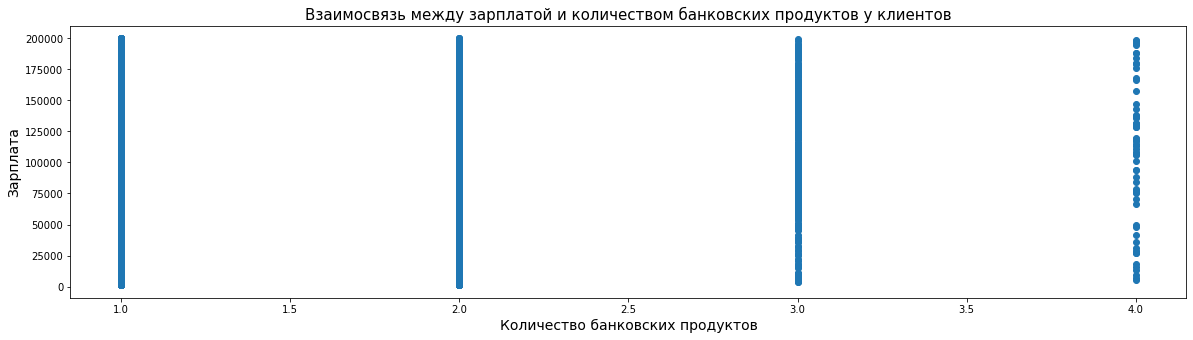

In [149]:
# проверим есть ли связь между зарплатой клиентов и количеством банковских продуктов

fig, ax = plt.subplots(figsize=(20, 5))

ax.scatter(x = data['products'], y = data['estimated_salary'])

ax.set_title('Взаимосвязь между зарплатой и количеством банковских продуктов у клиентов',fontsize=15)

ax.set_xlabel("Количество банковских продуктов",fontsize=14)

ax.set_ylabel("Зарплата",fontsize=14);

Как мы видим из диаграммы рессеяния, что связи между зарплатой и количеством банковских продуктов нет. Т.е. клиенты с высокой зарплатой могут иметь 1 банковский продукт, а клиенты, наоборот, с невысокой зарплатой - 3 и 4.

**Рассмотрим клиентов с кредитной картой.**

In [150]:
# в отдельной переменной рассчитаем количество клиентов с кредитной картой и без нее

count_client_cr_card = data.groupby('credit_card', as_index=False)['user_id']\
.count()\
.replace({0:'Без кредитной карты',1:'С кредитной картой'})

count_client_cr_card

,credit_card,user_id
0,Без кредитной карты,2927
1,С кредитной картой,7014


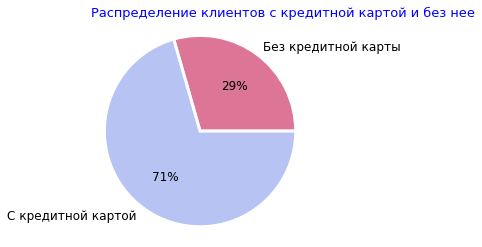

In [151]:
#  определим долю клиентов с кредитной картой и без нее с помощью круговой диаграммы

plt.pie(count_client_cr_card['user_id'],
        labels=count_client_cr_card['credit_card'],
        autopct='%1.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        radius=1.1,
        textprops={'fontsize': 12},
        colors=['#DD7596','#B7C3F3']);
  

plt.title('Распределение клиентов с кредитной картой и без нее',loc='left',color='b',fontsize = 13);

Как мы видим, среди клиентов банка преобладают клиенты с кредитной картой, их 71 %. Это хороший показатель для банка.

In [152]:
# сгруппируем и посчитаем какое количество кредитных карт выдается каждым банком

count_client_cr_card_city = data.groupby(['credit_card','city'], as_index=False)['user_id']\
.count()\
.replace({0:'Без кредитной карты',1:'С кредитной картой'})

# добавим столбец, в котором отразим долю клиентов

count_client_cr_card_city['share'] = round((count_client_cr_card_city['user_id'] /count_client_cr_card_city\
.groupby('city')['user_id']\
.transform(sum)) * 100, 2)

count_client_cr_card_city

,credit_card,city,user_id,share
0,Без кредитной карты,Ростов Великий,712,28.57
1,Без кредитной карты,Рыбинск,752,30.46
2,Без кредитной карты,Ярославль,1463,29.38
3,С кредитной картой,Ростов Великий,1780,71.43
4,С кредитной картой,Рыбинск,1717,69.54
5,С кредитной картой,Ярославль,3517,70.62


In [153]:
# построим барплот по выше приведенной таблице

fig = px.bar(count_client_cr_card_city,
             x='city',
             y='share',
             title='Процентное соотношение клиентов с кредитной картой и без нее по городам',
             color='credit_card',
             height=600,
             width=900,
             labels={'city':'Город', 'share':'%', 'credit_card':'Наличие кредитной карты'},
             barmode = 'group',
             color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

И головное отделение, и филиалы банка равномерно выдают кредитные карты клиентам. Около 70 % клиентов в каждом банке получили карту.

Проверим, с какими скоринговыми баллами клиенты получают кредитные карты.

In [154]:
# посчитаем клиентов в зависимости от категории скоринговых баллов и наличия кредитной карты

count_client_score_cr_card = data.query('credit_card == 1').groupby('score_category', as_index=False)['user_id']\
.count()\
.sort_values(by='user_id', ascending=False)

count_client_score_cr_card['share'] = round((count_client_score_cr_card['user_id'] /count_client_score_cr_card['user_id'].sum()) * 100, 2)

count_client_score_cr_card

,score_category,user_id,share
0,Надежный заемщик.Высокий шанс на лучшие условия,2444,34.84
2,Нельзя кредитоваться в крупных фин.организациях,1673,23.85
3,Приемлемый результат (запрос доп.документов),1323,18.86
4,Хороший показатель.Высокий шанс на стандартные...,1117,15.93
1,Невозможно получить займ,457,6.52


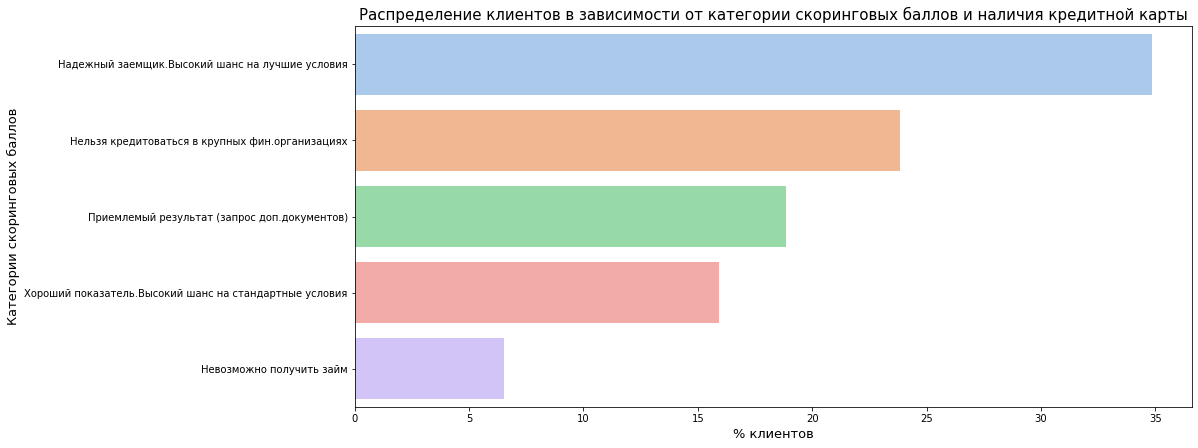

In [155]:
# построим барплот, где отразим процент клиентов, имеющих кредитную карту и распределенных по категориям скоринговых баллов

fig, ax = plt.subplots()

ax = sns.barplot(
    data=count_client_score_cr_card,
    y='score_category',
    x='share',
    palette='pastel')

ax.set_title('Распределение клиентов в зависимости от категории скоринговых баллов и наличия кредитной карты',fontsize=15)

ax.set_xlabel('% клиентов', fontsize=13)

ax.set_ylabel('Категории скоринговых баллов',fontsize=13)

fig.set_figheight(7) 

fig.set_figwidth(15)

Мы видим, что кредитные карты есть у тех клиентов, которые имеют невысокие скоринговые баллы, т.е. кредит либо вовсе невозможно получить от банка, либо кредитоваться лучше в некрупных финансовых организациях. Таких клиентов 30 %. Соответственно, бОльшую часть клиентов, у которых есть кредитная карта, составляют надежные заемщики.

Можно сделать следующий вывод о том, что скоринговые баллы напрямую не влияют на получение кредитной карты, но  могут влиять на сумму лимита на карте.

**Определим, клиенты какого возраста оформляют кредитную карту чаще.**

In [156]:
# посчитаем клиентов в зависимости от возраста и наличия кредитной карты

count_client_age_cr_card = data.query('credit_card == 1').groupby('range_age', as_index=False)['user_id']\
.count()\
.sort_values(by='user_id', ascending=False)

count_client_age_cr_card['share'] = round((count_client_age_cr_card['user_id'] /count_client_age_cr_card['user_id'].sum()) * 100, 2)

count_client_age_cr_card

,range_age,user_id,share
1,от 31 до 43,3834,54.66
0,от 18 до 30,1394,19.87
2,от 44 до 56,1272,18.14
3,от 57 до 69,406,5.79
4,от 70 до 82,104,1.48
5,от 83 до 92,4,0.06


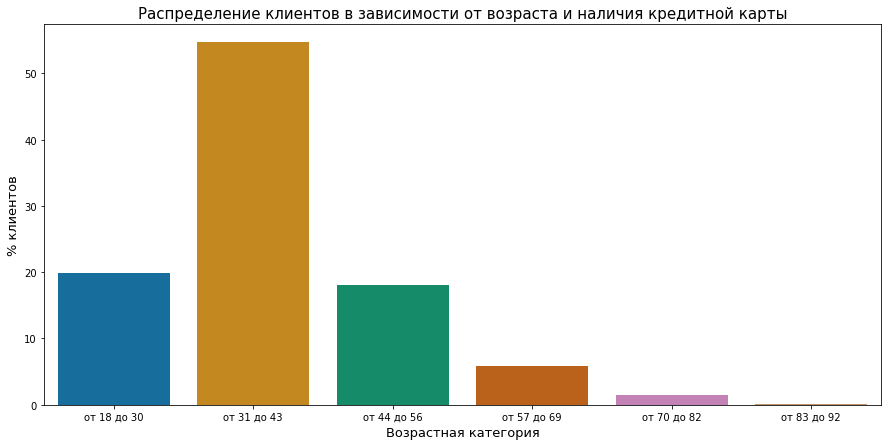

In [157]:
# построим барплот, где отразим процент клиентов, имеющих кредитную карту и распределенных по возрасту

fig, ax = plt.subplots()

ax = sns.barplot(
    data=count_client_age_cr_card,
    x='range_age',
    y='share',
    palette='colorblind')

ax.set_title('Распределение клиентов в зависимости от возраста и наличия кредитной карты',fontsize=15)

ax.set_xlabel('Возрастная категория', fontsize=13)

ax.set_ylabel('% клиентов',fontsize=13)

fig.set_figheight(7) 

fig.set_figwidth(15)

Больше 50 % клиентов имеют кредитную карту в возрасте от 31 до 43 лет. Около 20 % клиентов имеют карту в возрасте от 18 до 30  лет, а также в возрасте от 44 до 56 лет.  Также, есть карты и у клиентов в возрасте от 70 до 82 лет, они составляют 5 %.

<a id="churn"></a>
### Анализ оттока клиентов ###

**Проанализируем клиентов, которые отказались от обслуживания в банке.**

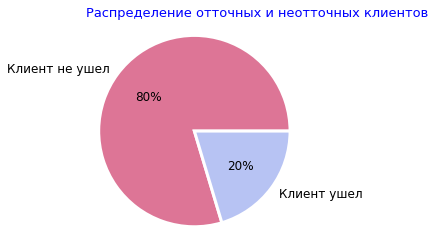

In [158]:
# построим круговую диаграмму, где отразим долю отточных и неотточных клиентов

count_churn_client = data.groupby('churn', as_index=False)['user_id'].count().replace({0:'Клиент не ушел',1:'Клиент ушел'})

plt.pie(count_churn_client['user_id'],
        labels=count_churn_client['churn'],
        autopct='%1.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        radius=1.1,
        textprops={'fontsize': 12},
        colors=['#DD7596','#B7C3F3']);
  

plt.title('Распределение отточных и неотточных клиентов',loc='left',color='b',fontsize = 13);

20 % клиентов отказались от обслуживания в банке.

In [159]:
# сохраним в переменной данные об отточных клиентах

data_outflow_clients = data.query('churn == 1')

#сохраним в переменной о клиентах, которые остались с банком

data_stayed_clients = data.query('churn == 0')

In [160]:
# сгруппируем данные и посчитаем количество отточных клиентов по городам

count_outflow_clients_city = data_outflow_clients.groupby('city',as_index=False)['user_id'].count()

count_outflow_clients_city

,city,user_id
0,Ростов Великий,806
1,Рыбинск,411
2,Ярославль,807


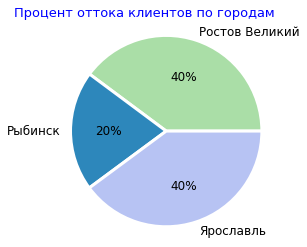

In [161]:
# построим круговую диаграмму, на которой отразим долю отточных клиентов по каждому городу


plt.pie(count_outflow_clients_city['user_id'],
        labels=count_outflow_clients_city['city'],
        autopct='%1.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        radius=1.1,
        textprops={'fontsize': 12},
        colors=['#AADEA7','#2D87BB','#B7C3F3']);
  

plt.title('Процент оттока клиентов по городам',loc='right',color='b',fontsize = 13);

По 40 % клиентов теряли банки в Ярославле и в Ростове Великом. Меньше всего клиентов, соответственно, ушло из банка в Рыбинске.

In [162]:
data_outflow_clients.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,range_age,score_category,range_salary
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,от 31 до 43,Приемлемый результат (запрос доп.документов),от 100 001 до 200 000
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,от 31 до 43,Нельзя кредитоваться в крупных фин.организациях,от 100 001 до 200 000
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1,от 44 до 56,Приемлемый результат (запрос доп.документов),от 100 001 до 200 000
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1,от 18 до 30,Невозможно получить займ,от 100 001 до 200 000
16,15780188,653,Ростов Великий,М,58,1,132602.88,1,1,0,5097.67,1,от 57 до 69,Хороший показатель.Высокий шанс на стандартные...,от 1 000 до 10 000


Составим портрет клиентов, которые ушли из банка. Рассмотрим такие критерии, как `пол, возраст, количество банковских продуктов, зарплата, скоринговые баллы.`

**Сравним соотношения женщин и мужчин, которые отказались от обслуживания и которые остались с банком.**

In [163]:
# сохраним в отдельных переменных количество мужчин и женщин в разрезе отточных и неотточных клиентов

count_outflow_gender = data_outflow_clients.groupby('gender')[['user_id']].count()

count_stayed_gender = data_stayed_clients.groupby('gender')[['user_id']].count()


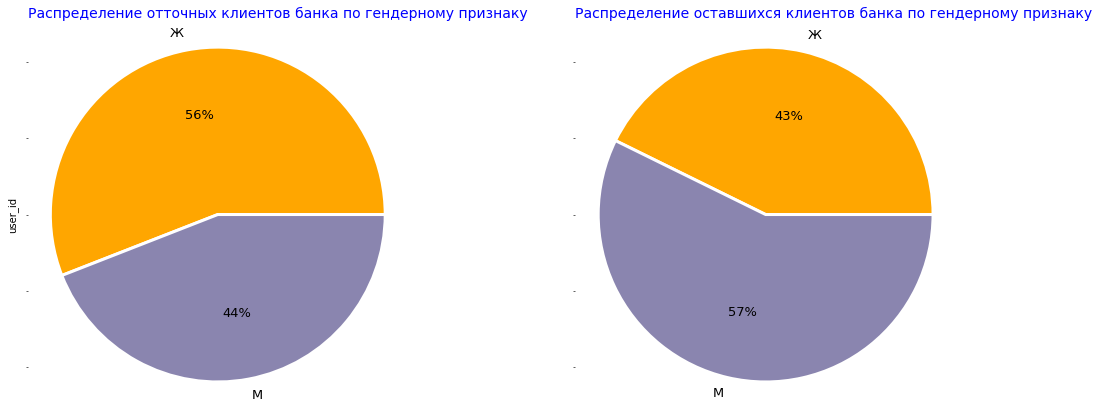

In [164]:
# построим круговые диаграммы

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(18,7))

count_outflow_gender.plot(kind='pie',
                          y= 'user_id',
                          ax=ax0,
                          subplots=True,
                          autopct='%1.0f%%',
                          wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
                          radius=1.1,
                          textprops={'fontsize': 13},
                          colors=['#FFA600','#8A85AF'],
                          legend=False);
ax0.set_title('Распределение отточных клиентов банка по гендерному признаку',loc='left',color='b',fontsize = 14)


count_stayed_gender.plot(kind='pie',
                         y='user_id',
                         ax=ax1,
                         subplots=True,
                         autopct='%1.0f%%',
                         wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'},
                         radius=1.1,
                         textprops={'fontsize': 13},
                         colors=['#FFA600','#8A85AF'],
                         legend=False);
ax1.set_title('Распределение оставшихся клиентов банка по гендерному признаку',loc='left',color='b',fontsize = 14);

Больше от банка отказалось женщин, они составили 56 %. 

А вот продолжили пользоваться банком, наоборот, больше мужчин, они составили 57 %.

**Определим, в каком возрасте  в основном отказываются от обслуживания в банке.**

In [165]:
# сохраним в отдельных переменных количество отточных в зависимости от возрастной категории

count_outflow_age = data_outflow_clients.groupby('range_age', as_index=False)['user_id']\
.count()

# в отдельном столбце посчитаем процент клиентов по каждой категории

count_outflow_age['share'] = round( (count_outflow_age['user_id'] / count_outflow_age['user_id'].sum() * 100), 2)


count_outflow_age

,range_age,user_id,share
0,от 18 до 30,148,7.31
1,от 31 до 43,765,37.80
2,от 44 до 56,868,42.89
3,от 57 до 69,228,11.26
4,от 70 до 82,14,0.69
5,от 83 до 92,1,0.05


In [166]:
# сохраним в отдельных переменных количество неотточных в зависимости от возрастной категории#

count_stayed_age = data_stayed_clients.groupby('range_age',as_index=False)['user_id']\
.count()

# добавим столбец, в котором отразим долю

count_stayed_age['share'] = round( (count_stayed_age['user_id'] / count_stayed_age['user_id'].sum() * 100), 2)

count_stayed_age

,range_age,user_id,share
0,от 18 до 30,1812,22.89
1,от 31 до 43,4635,58.54
2,от 44 до 56,989,12.49
3,от 57 до 69,347,4.38
4,от 70 до 82,128,1.62
5,от 83 до 92,6,0.08


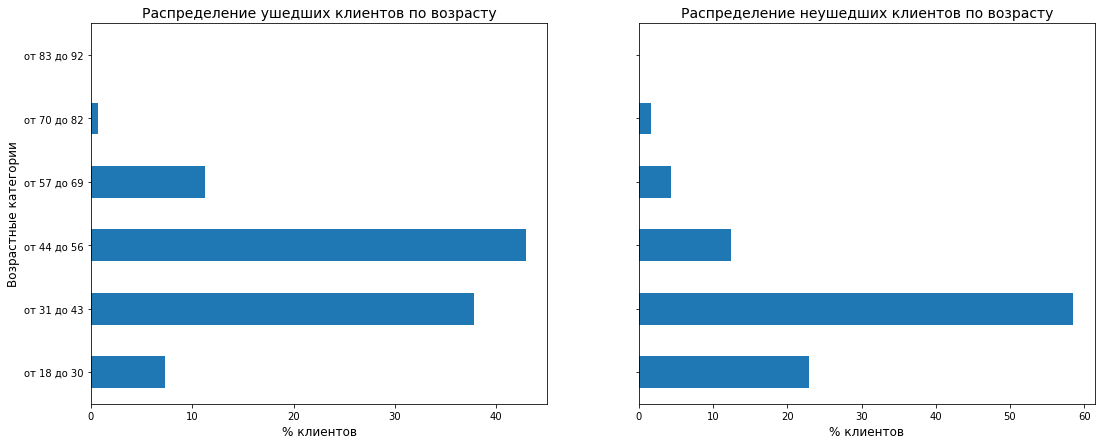

In [167]:
# отобразим в процентах отточных и неотточных клиентов в зависимости от возрастной категории с помощью барплотов

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(18,7))
count_outflow_age.\
plot(kind='barh', ax=ax0, legend=False, x='range_age',y='share')
ax0.set_title('Распределение ушедших клиентов по возрасту',fontsize= 14)
ax0.set_ylabel('Возрастные категории',fontsize= 12)
ax0.set_xlabel('% клиентов',fontsize= 12)


count_stayed_age.\
plot(kind='barh',ax=ax1,legend=False, x='range_age',y='share')
ax1.set_title('Распределение неушедших клиентов по возрасту',fontsize= 14)
ax1.set_ylabel('Возрастные категории',fontsize= 12)
ax1.set_xlabel('% клиентов',fontsize= 12);

Мы видим, что уходят в основном клиенты в возрасте от 44 до 56 лет, они составляют 42 %, также не менее активно уходят 37 % клиентов в возраста от 31 до 43 лет. Реже уходят клиенты до 30 лет и пожилые люди.

Что касается клиентов, которые не ушли, то 58 % составляют клиенты в возрасте от 31 до 43 лет. Больше 20 % клиентов остаются с банком в возрасте до 30 лет, что ,несомненно, являются плюсом.

**Проанализируем активность ушедших клиетов**

In [168]:
# сохраним в отдельных переменных количество активных и неактивных отточных в зависимости от возрастной категории

count_outflow_loyalty = data_outflow_clients.groupby('loyalty')[['user_id']]\
.count()

count_outflow_loyalty

,user_id
loyalty,
0,1294
1,730


In [169]:
# сохраним в отдельных переменных количество активных и неактивных неотточных клиентов

count_stayed_loyalty = data_stayed_clients.groupby('loyalty')[['user_id']]\
.count()

count_stayed_loyalty

,user_id
loyalty,
0,3532
1,4385


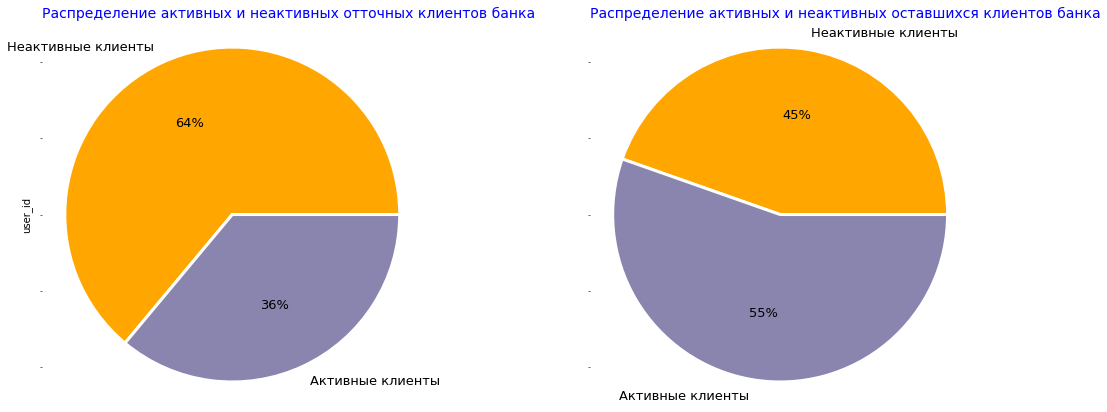

In [170]:
# построим круговые диаграммы

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(18,7))

count_outflow_loyalty.plot(kind='pie',
                          y= 'user_id',
                          ax=ax0,
                          subplots=True,
                          labels=['Неактивные клиенты','Активные клиенты'],
                          autopct='%1.0f%%',
                          wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
                          radius=1.1,
                          textprops={'fontsize': 13},
                          colors=['#FFA600','#8A85AF'],
                          legend=False);
ax0.set_title('Распределение активных и неактивных отточных клиентов банка',loc='left',color='b',fontsize = 14)


count_stayed_loyalty.plot(kind='pie',
                         y='user_id',
                         ax=ax1,
                         subplots=True,
                         autopct='%1.0f%%',
                         labels=['Неактивные клиенты','Активные клиенты'],
                         wedgeprops = {'linewidth' : 3, 'edgecolor' : 'white'},
                         radius=1.1,
                         textprops={'fontsize': 13},
                         colors=['#FFA600','#8A85AF'],
                         legend=False);
ax1.set_title('Распределение активных и неактивных оставшихся клиентов банка',loc='left',color='b',fontsize = 14);

Среди ушедших клиентов бОльшую часть, а именно 64 %, составляли неактивные клиенты. А вот среди оставшихся, наоборот, больше половины составили активные.

**Определим, какую зарплату имеют отточные клиенты,а какую зарплату - неотточные клиенты.**

In [171]:
# сгруппируем данные в зависимости от того остался или ушел клиент, а также по зарплате
# и выясним какую зарплату имеют чаще отточные клиенты

count_churn_salary = data.groupby(['churn','range_salary'], as_index=False)['user_id']\
.count()\
.sort_values(by='user_id',ascending=False)\
.replace({0:'Клиент не ушел', 1:'Клиент ушел'})

count_churn_salary['share'] = round(
    (count_churn_salary['user_id'] / count_churn_salary.groupby('churn')['user_id']\
                                      .transform(sum)) * 100,
    2)

count_churn_salary

,churn,range_salary,user_id,share
5,Клиент не ушел,от 100 001 до 200 000,3966,50.09
3,Клиент не ушел,от 50 001 до 80 000,1227,15.50
11,Клиент ушел,от 100 001 до 200 000,1044,51.58
4,Клиент не ушел,от 80 001 до 100 000,806,10.18
2,Клиент не ушел,от 30 001 до 50 000,788,9.95
1,Клиент не ушел,от 10 001 до 30 000,769,9.71
0,Клиент не ушел,от 1 000 до 10 000,361,4.56
9,Клиент ушел,от 50 001 до 80 000,308,15.22
7,Клиент ушел,от 10 001 до 30 000,201,9.93
10,Клиент ушел,от 80 001 до 100 000,196,9.68


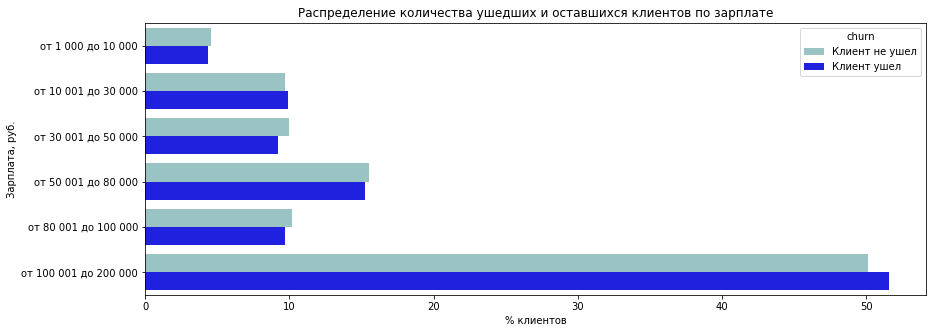

In [172]:
# отобразим распределение отточных и неотточных клиентов по зарплате


fig, ax = plt.subplots(figsize = (14,5))

ax = sns.barplot(y='range_salary',
            x='share',
            hue="churn",
            data=count_churn_salary,
            palette=['#93CACA', 'blue'])

ax.set_title('Распределение количества ушедших и оставшихся клиентов по зарплате')
ax.set(xlabel='% клиентов', ylabel='Зарплата, руб.');

Мы видим, что клиенты, которые ушли и которые остались, имеют примерно одинаковые зарплаты. Так, например, высокую зарплату, а именно больше 100 тыс. руб., получают 51,5 % отточных клиентов и 50 % неотточных клиентов. Для банка, конечно, невыгодно, чтобы уходили клиенты с высоким доходом, поскольку иметь надежных клиентов даст банку бОльшую уверенность, например, в возращении кредитов в установленные сроки.

**Определим, какое количество отточных и неотточных клиентов имеют банковские продукты**

In [173]:
# посчитаем и сохраним в отдельной переменной число  отточных клиентов по каждому числу имеющихся продуктов банка

count_outflow_products = data_outflow_clients.groupby('products', as_index=False)['user_id']\
.count()\
.sort_values(by='user_id', ascending=False)

count_outflow_products['share'] = round((count_outflow_products['user_id'] /count_outflow_products['user_id'].sum()) * 100, 2)

count_outflow_products

,products,user_id,share
0,1,1399,69.12
1,2,345,17.05
2,3,220,10.87
3,4,60,2.96


In [174]:
# посчитаем и сохраним в отдельной переменной число  неотточных клиентов по каждому числу имеющихся продуктов банка

count_stayed_products = data_stayed_clients.groupby('products',as_index=False)['user_id']\
.count()\
.sort_values(by='user_id', ascending=False)

count_stayed_products['share'] = round((count_stayed_products['user_id'] /count_stayed_products['user_id'].sum()) * 100, 2)

count_stayed_products

,products,user_id,share
1,2,4217,53.27
0,1,3654,46.15
2,3,46,0.58


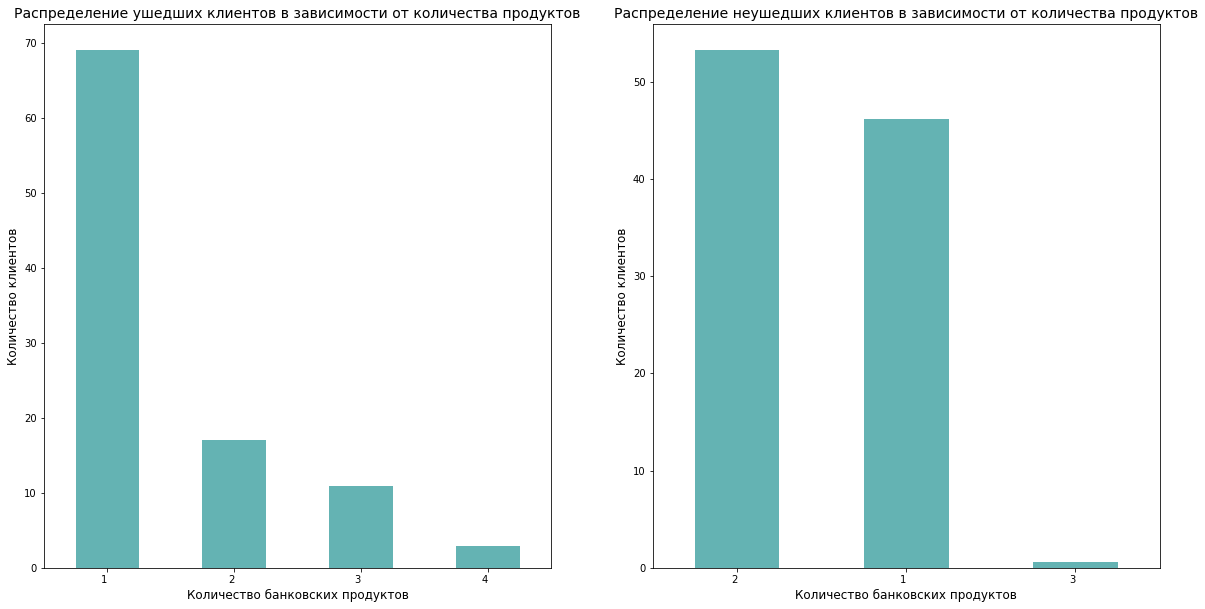

In [175]:
# отобразим в процентах отточных и неотточных клиентов в зависимости от зарплаты с помощью барплотов

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
count_outflow_products.\
plot(kind='bar', ax=ax0, legend=False, x='products',y='share', color='#64B3B3')
ax0.set_title('Распределение ушедших клиентов в зависимости от количества продуктов',fontsize= 14)
ax0.set_ylabel('Количество клиентов',fontsize= 12)
ax0.set_xlabel('Количество банковских продуктов',fontsize= 12)


count_stayed_products.\
plot(kind='bar',ax=ax1,legend=False, x='products',y='share', color='#64B3B3')
ax1.set_title('Распределение неушедших клиентов в зависимости от количества продуктов',fontsize= 14)
ax1.set_ylabel('Количество клиентов',fontsize= 12)
ax1.set_xlabel('Количество банковских продуктов',fontsize= 12)

plt.setp(ax0.get_xticklabels() + ax1.get_xticklabels(), rotation=360, ha='right');

БОльшая часть ушедших клиентов, а их около 70%, имели 1 банковский продукт. Для сравнения основная часть оставшихся клиентов,  больше 50%, имеют 2 банковских продукта.

**Определим, как много ушедших клиентов имели хорошие скоринговые баллы и сравним это количество с оставшимися клиентами**

In [176]:
# сохраним в переменных количество отточных и неотточных клиентов в зависимости от категории скоринговых баллов

count_churn_score = data.groupby(['churn','score_category'], as_index=False)['user_id']\
.count()\
.sort_values(by='user_id',ascending=False)\
.replace({0:'Клиент не ушел', 1:'Клиент ушел'})

count_churn_score['share'] = round( (count_churn_score['user_id'] / count_churn_score.groupby('churn')['user_id'].transform(sum)) * 100, 2)

count_churn_score

,churn,score_category,user_id,share
0,Клиент не ушел,Надежный заемщик.Высокий шанс на лучшие условия,2790,35.24
2,Клиент не ушел,Нельзя кредитоваться в крупных фин.организациях,1880,23.75
3,Клиент не ушел,Приемлемый результат (запрос доп.документов),1468,18.54
4,Клиент не ушел,Хороший показатель.Высокий шанс на стандартные...,1298,16.40
5,Клиент ушел,Надежный заемщик.Высокий шанс на лучшие условия,689,34.04
7,Клиент ушел,Нельзя кредитоваться в крупных фин.организациях,508,25.10
1,Клиент не ушел,Невозможно получить займ,481,6.08
8,Клиент ушел,Приемлемый результат (запрос доп.документов),384,18.97
9,Клиент ушел,Хороший показатель.Высокий шанс на стандартные...,294,14.53
6,Клиент ушел,Невозможно получить займ,149,7.36


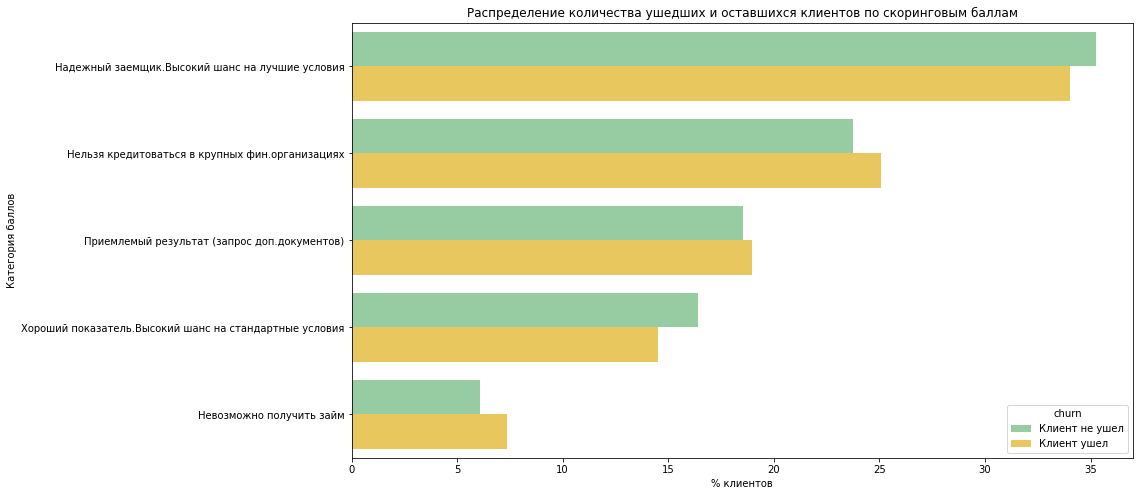

In [177]:
# построим столбчатую диаграмму

fig, ax = plt.subplots(figsize = (14,8))

ax = sns.barplot(y='score_category',
            x='share',
            hue="churn",
            data=count_churn_score,
            palette=['#8ED49C', '#FFD447'])

ax.set_title('Распределение количества ушедших и оставшихся клиентов по скоринговым баллам')
ax.set(xlabel='% клиентов', ylabel='Категория баллов');

На данной диаграмме среди ушедших клиентов 34 % являются надежными, что, безусловно, считается неблагоприятным показателем для банка. Но есть и плюс - среди оставшихся клиентов бОльший процент составляют тоже надежные клиенты, их 35 %. 

В целом, сильной разницы между группами нет. Но необходимо в дальнейшем учитывать тот факт, что банк теряет надежных клиентов.

**Сравним ушедших клиентов с оставшимися по наличию кредитной карты.**

In [178]:
#

count_churn_cr_card = data.groupby(['churn','credit_card'], as_index=False)[['user_id']]\
.count()


count_churn_cr_card['churn'] = count_churn_cr_card['churn'].replace({0:'Клиент ушел', 1:'Клиент не ушел'})

count_churn_cr_card['credit_card'] = count_churn_cr_card['credit_card']\
.replace({0:'Нет кредитной карты', 1:'Есть кредитная карта'})


count_churn_cr_card['share'] = round( (count_churn_cr_card['user_id'] / count_churn_cr_card.groupby('churn')['user_id'].transform(sum)) * 100, 2)


count_churn_cr_card

,churn,credit_card,user_id,share
0,Клиент ушел,Нет кредитной карты,2320,29.30
1,Клиент ушел,Есть кредитная карта,5597,70.70
2,Клиент не ушел,Нет кредитной карты,607,29.99
3,Клиент не ушел,Есть кредитная карта,1417,70.01


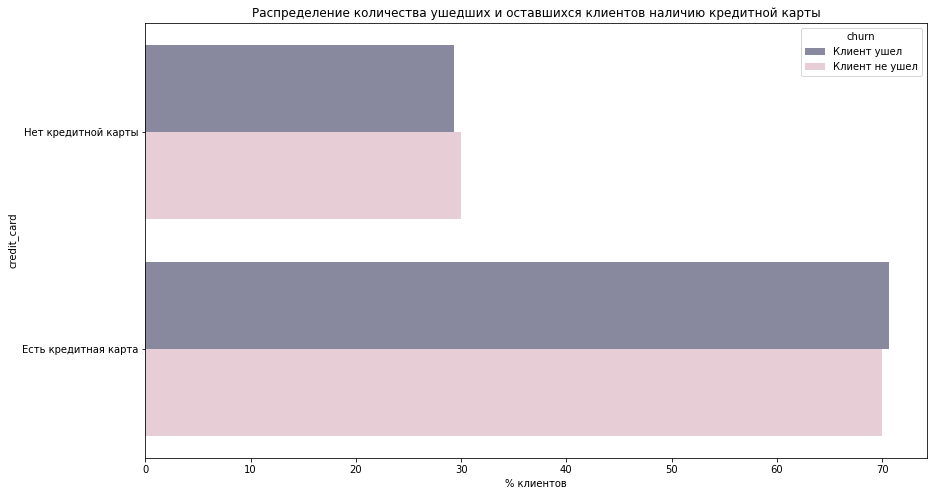

In [179]:
# построим столбчатую диаграмму

fig, ax = plt.subplots(figsize = (14,8))

ax = sns.barplot(y='credit_card',
            x='share',
            hue="churn",
            data=count_churn_cr_card,
            palette=['#8485A3', '#EBCAD5'])

ax.set_title('Распределение количества ушедших и оставшихся клиентов наличию кредитной карты')
ax.set(xlabel='% клиентов');

70%  оставшихся, и  70 % ушедших клиентов оформляли кредитную карту.

Теперь построим тепловую  карту для отражения коэффициентов корреляции по каждому признаку в разбивке по ушедшим и оставшимся клиентам.

In [180]:
# уберем из расчета коэффициентов корреляции значения столбца 'user_id'

data_corr = data.drop(columns='user_id')

# применим унитарное кодирование, чтобы преобразовать значение каждой категории в новый столбец
# и присвоить столбцу значение 1 или 0 (Истина / Ложь)

data_corr = pd.get_dummies(data_corr, columns=["gender", "city"]).head(30)

data_corr.head()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,range_age,score_category,range_salary,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,619,42,2,NaN,1,1,1,101348.88,1,от 31 до 43,Приемлемый результат (запрос доп.документов),от 100 001 до 200 000,1,0,0,0,1
1,608,41,1,83807.86,1,0,1,112542.58,0,от 31 до 43,Приемлемый результат (запрос доп.документов),от 100 001 до 200 000,1,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,от 31 до 43,Нельзя кредитоваться в крупных фин.организациях,от 100 001 до 200 000,1,0,0,0,1
3,699,39,1,NaN,2,0,0,93826.63,0,от 31 до 43,Надежный заемщик.Высокий шанс на лучшие условия,от 80 001 до 100 000,1,0,0,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,от 31 до 43,Надежный заемщик.Высокий шанс на лучшие условия,от 50 001 до 80 000,1,0,0,1,0


In [181]:
data_corr.dtypes

score                     int64
age                       int64
objects                   int64
balance                 float64
products                  int64
credit_card               int64
loyalty                   int64
estimated_salary        float64
churn                     int64
range_age              category
score_category           object
range_salary           category
gender_Ж                  uint8
gender_М                  uint8
city_Ростов Великий       uint8
city_Рыбинск              uint8
city_Ярославль            uint8
dtype: object

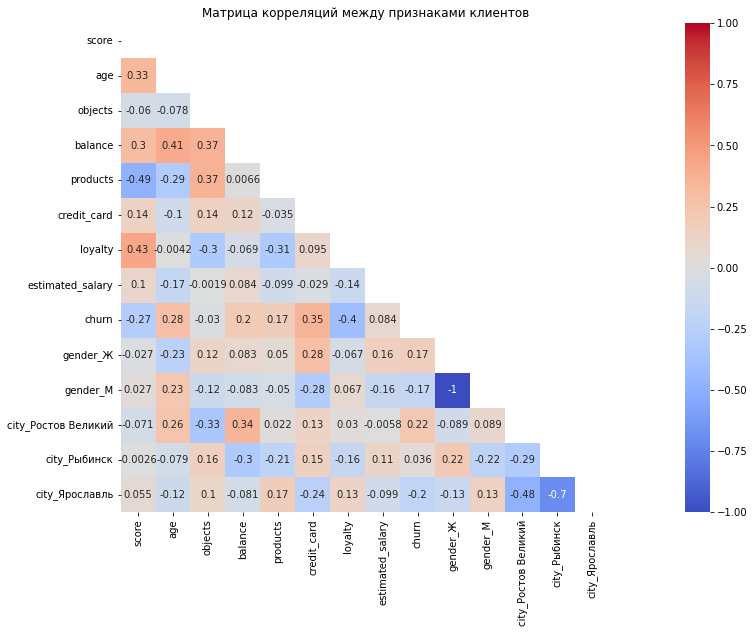

In [182]:
# зададим переменную, в которой сохраним изменение формы матрицы с прямоугольной на треугольную

matrix = np.triu(data_corr.corr())

# построим тепловую карту

fig, ax = plt.subplots(figsize = (27,9))

ax = sns.heatmap(data_corr.corr(),
                 annot = True,
                 fmt = '.2g',
                 center= 0,
                 cmap= 'coolwarm',
                 square=True,
                 mask=matrix,
                 vmin= -1,
                 vmax=1)
plt.title('Матрица корреляций между признаками клиентов');

На данной тепловой карте мы видим в основном отсутствие линейной связи между признаками.  

Коэффициенты в диапазоне `от 0,23 до 0,43 и от -0,22 до -0,49` характеризуют слабую корреляционная связь между признаками. Отрицательная корреляция означает, что при изменении значения одного признака изменяется в противоположную сторону значение второго признака. Но о причинно - следственных связях мы сказать по коэффициентам корреляции не можем.

Сильная обратная корреляция прослеживается между гендерными признаками, она составляет -1. Т.е. при изменении количества мужчин, количество женщин может эквивалетно изменяться в противоположном направлении.

Среднюю корреляционную связь мы видим между городами - Рыбинском и Ярославлем. Обратная корреляция составляет -0,7.

<a id="section_conclusion"></a>
**Выводы по данному разделу**

В данном разделе был проведен общий анализ клиентов банка, а также проведен анализ клиентов по двум группам - те, которые ушли, и те клиенты, которые остались.

***Составим портрет клиентов, которые склонны уходить:***

1. Чаще уходят женщины.
2. Возраст - от 44 до 56 лет.
3. Зарплата у клиента в основном  от 100 тыс. руб. и выше.
4. Клиент имеет чаще один банковский продукт.
5. Клиент имеет высокие скоринговые баллы, что говорит о высокой надежности клиента.
6. Чаще клиенты оформляют кредитную карту.
7. В основном клиенты неактивны.

***Составим портрет клиента, который несклонен уходить:***

1. Мужчин,как правило, больше.
2. Возраст клиентов в основном от 31 до 43 лет.
3. Половина оставшихся клиентов имеют зарплату выше 100 тыс. руб.
4. Клиент имеет чаще два банковских продукта.
5. Клиент имеет высокий уровень скоринговых баллов.
6. Чаще клиенты оформляют кредитную карту.
7. Чаще клиенты активны.

Итак, мы видим, что ушедшие и оставшиеся клиенты имеют много схожих признаков. 

В основном различия по возрасту, гендерному признаку, активности, и в количестве имеющихся банковских продуктах.

Для определения статистически значимого различия между группами клиентов, воспользуемся статистическими методами.

Также, мы рассчитали коэффициенты корреляции по всем признакам. Получили коэффициенты в диапазоне от 0,23 до 0,43 и от -0,22 до -0,49, что характеризует слабую корреляционная связь между признаками.

Сильная обратная корреляция прослеживается между гендерными признаками, она составляет -1.

Среднюю корреляционную связь мы видим между городами - Рыбинском и Ярославлем. Обратная корреляция составляет -0,7.

<a id="hypotheses"></a>
## Проверка статистических гипотез ##

Нам необходимо при проверке гипотез обратиться к таким столбцам, как 'estimated_salary', 'products','score'.

Прежде чем приступить к самой проверке и выбрать соответствующий для этого метод, необходимо сформировать две выборки - доход ушедших клиентов и доход оставшихся клиентов, и выяснить, нормально ли распределены данные выборки.   
Для этого воспользуемся методом Шапиро-Уилка,а также построим гистограммы.

In [183]:
# сохраним в 2-х переменных данные о зарплате по ушедшим и оставшимся клиентам

sample_outflow_salary = data_outflow_clients['estimated_salary']

sample_stayed_salary = data_stayed_clients['estimated_salary']

Проверим гипотезу о том, что данные в двух выборках нормально распределены.

**Сформулируем нулевую и альтернативную гипотезы:**

H0: Данные в выборках распределены нормально.

H1: Данные в выборках распределены ненормально.

In [184]:
# установим критерий статистической значимости

alpha = 0.5

# применим метод Шапиро-Уилка для первой выборки

results = st.shapiro(sample_outflow_salary)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  5.340174176371009e-25
Отвергаем нулевую гипотезу: распределение не нормально


In [185]:
# установим критерий статистической значимости

alpha = 0.5

# применим метод Шапиро-Уилка для второй выборки

results = st.shapiro(sample_stayed_salary)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  5.002635517639597e-43
Отвергаем нулевую гипотезу: распределение не нормально


C:\Users\User\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



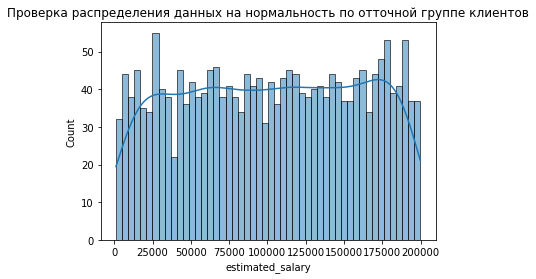

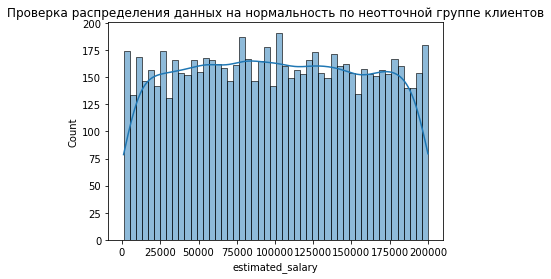

In [186]:
# проверим распределение еще и с помощью гистограмм по двум выборкам

sns.histplot(data=sample_outflow_salary,bins=50, kde=True)

plt.title('Проверка распределения данных на нормальность по отточной группе клиентов')

plt.show()

sns.histplot(data=sample_stayed_salary,bins=50, kde=True)

plt.title('Проверка распределения данных на нормальность по неотточной группе клиентов')

plt.show()

Значения в двух выборках нормально не распределены. Это означает, что в качестве статистического метода нам подойдет тест Уилкоксона-Манна-Уитни. 

**Проверим гипотезу о том, что на отток клиентов влияет значимое различие в доходах между ушедшими и оставшимися клиентами.**

**Сформулируем нулевую и альтернативную гипотезы:**

H0: Доходы между ушедшими и неушедшими клиентами не различаются.


H1: Доходы между ушедшими и неушедшими клиентами  различаются.

In [187]:
# установим критерий статистической значимости

alpha = 0.05

# применим метод Уилкоксона-Манна-Уитни

results = st.mannwhitneyu(sample_outflow_salary, sample_stayed_salary)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  0.20692526049302318
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Отвергнуть нулевую гипотезу не получилось. Значимой разницы между доходами двух групп нет, т.е. разница медиан в выборках случайна.

**Теперь проверим гипотезу о том, что на отток клиентов влияют значимые различия в количестве банковских продуктов между ушедшими и неушедшими клиентами.**

In [188]:
# сохраним в 2-х переменных данные о количестве продуктов по ушедшим и оставшимся клиентам

sample_outflow_products = data_outflow_clients['products']

sample_stayed_products = data_stayed_clients['products']

При проверке гипотезы здесь также потребуется применение теста Уилкоксона-Манна-Уитни.

**Сформулируем нулевую и альтернативную гипотезы:**

H0: Количество банковских продуктов между ушедшими и неушедшими клиентами не различаются.

H1: Количество банковских продуктов между ушедшими и неушедшими клиентами различаются.

In [189]:
# установим критерий статистической значимости

alpha = 0.05

# применим метод Уилкоксона-Манна-Уитни

results = st.mannwhitneyu(sample_outflow_products, sample_stayed_products)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  2.333285000481772e-35
Отвергаем нулевую гипотезу: разница статистически значима


В этот раз мы получили противоположный результат. Существует значимая разница между количеством банковских продуктов двух групп.

**Проверим гипотезу о том, что на отток клиентов влияют значимые различия в количестве скоринговых баллов между ушедшими и неушедшими клиентами.**

In [190]:
# сохраним в 2-х переменных данные о полученных скоринговых баллах по ушедшим и оставшимся клиентам

sample_outflow_score = data_outflow_clients['score']

sample_stayed_score = data_stayed_clients['score']

**Сформулируем нулевую и альтернативную гипотезы:**

H0: Количество скоринговых баллов между ушедшими и неушедшими клиентами не различаются.

H1: Количество скоринговых баллов между ушедшими и неушедшими клиентами различаются.

In [191]:
# установим критерий статистической значимости

alpha = 0.05

# применим метод Уилкоксона-Манна-Уитни

results = st.mannwhitneyu(sample_outflow_score, sample_stayed_score)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  0.021301372121546612
Отвергаем нулевую гипотезу: разница статистически значима


Разница между скоринговыми баллами статистически значима, это говорит о том, что различия между группами не могли пройзойти случайно.

По итогам проверки 3-х гипотез можно сделать вывод о том, что на отток клиентов влияет разница в количестве банковских продуктов и разница в скоринговых баллах между ушедшими и оставшимися клиентами. 

Разница в уровне дохода получилась статистически незначимой между группами клиентов, и поэтому данный показатель при прогнозе оттока клиентов можно либо использовать в последнюю очередь, либо вовсе исключить.

<a id="total"></a>
## Выводы ##

Итак, мы провели такие этапы анализа, как предобработка данных,  исследовательский анализ в целом по клиентам, изучили отток клиентов и провели проверку трех гипотез.

`В целом по клиентам банка мы можем сказать следующее:`

1. Чаще встречаются в качестве клиентов мужчины.


2. Больше половины клиентов в возрасте от 31 года до 43 лет.


3. 35 % клиентов имеет высокие скоринговые баллы. Это говорит о том, что банк сможет рассчитывать на получение дохода в течение всего срока кредитования заемщиков. Но также немалый процент, а именно 24 %, составляют клиенты с невысокими баллами, для которых больше подойдет кредитование в малых финансовых организациях. Получить кредитование вовсе не смогут 6 % клиентов.


4. Мы выяснили, что скоринговые баллы не берут в расчет количество объектов в собственности у клиента.


5. Уровень зарплат у клиентов находится на хорошем уровне и подтверждает тот факт, что надежных клиентов у банка больше.


6. Чаще клиенты имеют 1-2 банковских продукта. Очень редко, когда мы можем встретить клиента, который имеет 4 продукта.


7. Среди клиентов банка преобладают клиенты с кредитной картой, их 71 %. Это хороший показатель для банка. И головное отделение, и филиалы банка равномерно выдают кредитные карты клиентам. Также, мы выяснили, что скоринговые баллы напрямую не влияют на получение кредитной карты, но могут влиять на сумму лимита на карте.


8. Неактивных клиентов больше, чем активных, но незначительно, всего на 2 %.

`Теперь сделаем выводы по оттоку клиентов.`

Мы составили портрет клиента, который склонен уходить:

1. Чаще уходят женщины.
2. Возраст - от 44 до 56 лет.
3. Зарплата у клиента в основном от 100 тыс. руб. и выше.
4. Клиент имеет чаще один банковский продукт.
5. Клиент имеет высокие скоринговые баллы, что говорит о высокой надежности клиента.
6. Чаще клиенты оформляют кредитную карту
7. В основном клиенты неактивны.

`Также, мы составили для сравнения портрет клиентов, которые не склонны уходить:`

1. Мужчин,как правило, больше.
2. Возраст клиентов в основном  от 31 до 43 лет.
3. Половина оставшихся клиентов имеют зарплату выше 100 тыс. руб.
4. Клиент имеет чаще два банковских продукта.
5. Клиент имеет высокий уровень скоринговых баллов.
6. Чаще клиенты оформляют кредитную карту.
7. Чаще клиенты активны.

Мы провели проверку трех гипотез с помощью статистического теста Уилкоксона-Манна-Уитни и выявили, что существуют статистически значимые различия между двумя группами по количеству скоринговых баллов и по количеству банковских продуктов.  Это значит, что при прогнозе оттока клиентов необходимо учитывать количество банковских продуктов и скоринговые баллы.

Для того, чтобы снизить отток клиентов могут быть рекомендованы несколько действий.

1. Так как большинство клиентов имеют высокий уровень зарплаты, можно чаще клиентам предлагать выгодные банковские продукты. Во-первых, число банковских продуктов вырастет, во-вторых, банк будет получать больше дохода, в-третьих, клиенты будут больше привязаны к банку и,соответственно, вероятность оттока будет ниже.


2. Стоит пересмотреть систему начисления скоринговых баллов из-за чего у клиентов появятся больше возможностей и, они не станут искать выгодные предложения у конкурентов.


3. Провести опрос среди женщин для определения причин ухода. Также, провести опрос среди клиентов в возрасте от 44 до 56 лет. Это поможет выявить слабые стороны обслуживания, банковских продуктов.  


4. Для того, чтобы увеличить активность клиентов, необходимо вовлечь клиентов пользоваться, к примеру, мобильным приложением или интернет-банком. Так как пользователи, которые склонны уходить, в основном в зрелом возрасте и не всем может быть интуитивно понятно, как пользоваться приложением/ интернет-банком, сотрудники банка могут в этом помочь. Т.е. необходимо разработать план действий для сотрудников банка активно мотивировать клиентов и помогать им пользоваться цифровыми платформами.   
Также, для увеличения транзакций можно предлагать клиентам дебетовые карты с привлекательными условиями - без комиссий или с минимальной комиссией, кэшбек от партнеров (если возможности банка позволяют). Для выполнения данной рекомендации по внедрению нового, необходимо прежде всего сравнить банк с  конкурентами.